In [1]:
from dotenv import load_dotenv
load_dotenv()
import sys
sys.path.append("network/hvae")

from torch.nn.functional import interpolate
from torchvision.transforms.functional import to_pil_image
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms as T
from torchvision.datasets import FashionMNIST
from matplotlib import pyplot as plt
from network.hvae.oodd.losses import ELBO
import os
import typing as t
import gzip
import torch
import json
import surprisenet.packnet as pn
from surprisenet.task_inference import TaskInferenceStrategy
from network.deep_vae import FashionMNISTDeepVAE
from tqdm import tqdm
from config.config import ExpConfig
import pickle
import matplotlib

load_dotenv()

plt.rcParams.update(
    {
        'font.family': 'Alegreya Sans',
        'font.size': 12,
        "image.cmap": "cividis"
    }
)


elbo_loss_func = ELBO()
RUN_ROOT="/local/scratch/antonlee/log/SurpriseNet/cuda9/0006_LrLatentSearch"
MODEL_FILENAME = f"{RUN_ROOT}/model.pt.gz"
CONFIG_FILENAME = f"{RUN_ROOT}/config.json"
RESULT_FILENAME = f"{RUN_ROOT}/results.pkl.gz"
CLASS_ORDER_FILENAME = f"{RUN_ROOT}/class_order.txt"
ROOT="/local/scratch/antonlee/datasets/"

cfg = ExpConfig.from_json(CONFIG_FILENAME)
cfg.dataset_root = ROOT

TASK_COMP = []
with open(CLASS_ORDER_FILENAME, "r") as f:
    lines = f.readlines()
    for line in lines:
        TASK_COMP.append([int(x) for x in line.split(",")])

with gzip.open(RESULT_FILENAME, "rb") as f:
    results = pickle.load(f)

CLASS_TO_TASK = {}
for task, classes in enumerate(TASK_COMP):
    for y in classes:
        CLASS_TO_TASK[y] = task

print("Task Composition: ", TASK_COMP)

# Pretty print results
final_task = results[-1]
for metric, value in final_task.items():
    print(f"\t{metric}: {value}")

Task Composition:  [[0, 1], [2, 3], [4, 5], [6, 7], [8, 9]]
	Loss_Epoch/train_phase/train_stream/Task000: 2946.445391276042
	clock/0000_epoch: 179
	Top1_Acc_Epoch/train_phase/train_stream/Task000: 0.07583333333333334
	TrainLossPart/DeepVAE: 2946.41473778258
	Loss_Exp/eval_phase/test_stream/Task000/Exp000: 2290.1301015625
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000: 0.0675
	EvalLossPart/Experience_0/DeepVAE: 2292.3350524902344
	Loss_Exp/eval_phase/test_stream/Task000/Exp001: 2695.017615234375
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001: 0.096
	EvalLossPart/Experience_1/DeepVAE: 2694.731231689453
	Loss_Exp/eval_phase/test_stream/Task000/Exp002: 2702.35795703125
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp002: 0.0215
	EvalLossPart/Experience_2/DeepVAE: 2702.5309448242188
	Loss_Exp/eval_phase/test_stream/Task000/Exp003: 2696.3696015625
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp003: 0.241
	EvalLossPart/Experience_3/DeepVAE: 2697.7618103027344
	Loss_Exp/eval_phase/t

In [2]:
# Load Model
from network.deep_vae import HVAE
from train import Experiment

cfg.tensorboard_dir = "experiment_logs"
exp = Experiment(cfg)
model: HVAE = exp.network

with gzip.open(MODEL_FILENAME, "rb") as f:
    state_dict = torch.load(f)

    # Renamed keys
    for key in list(state_dict.keys()):
        if key.startswith("encoder."):
            state_dict[key.replace("encoder.", "_encoder.")] = state_dict.pop(key)
        if key.startswith("decoder."):
            state_dict[key.replace("decoder.", "_decoder.")] = state_dict.pop(key)
        if key.startswith("classifier."):
            state_dict[key.replace("classifier.", "_classifier.")] = state_dict.pop(key)

    model.load_state_dict(state_dict, strict=True)
    # model.wrapped.classifier = None

DeepVAE Loss: Initializing warmup and free nats
ExperienceIdentificationCM


In [3]:
# Setup Dataset
def split_by_class(dataset: Dataset) -> t.List[Dataset]:
    """Split a dataset into a list of datasets, where each dataset contains only
    one class.
    """
    classes = set(map(int, dataset.targets))
    datasets = []
    for y in classes:
        indices = torch.where(dataset.targets == y)[0]
        datasets.append(Subset(dataset, indices))
    return datasets

def random_batch(dataset: Dataset, batch_size: int) -> t.Tuple[torch.Tensor, torch.Tensor]:
    """Return a random batch of `batch_size` from `dataset`
    """
    indices = torch.randperm(len(dataset))[:batch_size]
    x = torch.stack([dataset[i][0] for i in indices])
    y = torch.tensor([dataset[i][1] for i in indices])
    return x, y

def display_batch(x: torch.Tensor, scale: float = 4.0, rows: int = 3):
    """Display a batch of images in a grid
    """
    x = interpolate(x, scale_factor=scale, mode="nearest")
    image_grid = make_grid(x, nrow=rows, pad_value=1.0)
    return to_pil_image(image_grid)
    
transform = T.Compose([
    T.ToTensor(),
    T.Resize((32, 32), antialias=True),
])

joint_dataset = FashionMNIST(ROOT, train=False, transform=transform)
test_sets = split_by_class(joint_dataset)
display_batch(random_batch(test_sets[0], 9)[0])

joint_dataset.taskid = torch.tensor([CLASS_TO_TASK[int(y)] for y in joint_dataset.targets]) # type: ignore

In [4]:
from sklearn.manifold import TSNE

model.eval()
model.cuda()

active_task = 4
model.use_task_subset(active_task)




dataloader = DataLoader(joint_dataset, batch_size=100, shuffle=False)

# mean_stage_0 = []
# means_stage_1 = []
z_stage = []
with torch.no_grad():
    for x, y in tqdm(dataloader):
        x = x.cuda()
        likelihood, stage_data = model.wrapped.forward(x)

        # mean_stage_0.append(stage_data[0].q.mean)
        # means_stage_1.append(stage_data[1].q.mean)
        z_stage.append(stage_data[2].q.z)


# mean_stage_0 = torch.cat(mean_stage_0)
# means_stage_1 = torch.cat(means_stage_1)
z_stage = torch.cat(z_stage)


100%|██████████| 100/100 [00:07<00:00, 13.53it/s]


In [5]:
# t-sne
tsne = TSNE(n_components=2, random_state=0)
print("Fitting t-sne")
numpy_z = z_stage.flatten(start_dim=1).detach().cpu().numpy()
z_2d = tsne.fit_transform(numpy_z)

Fitting t-sne


KeyboardInterrupt: 

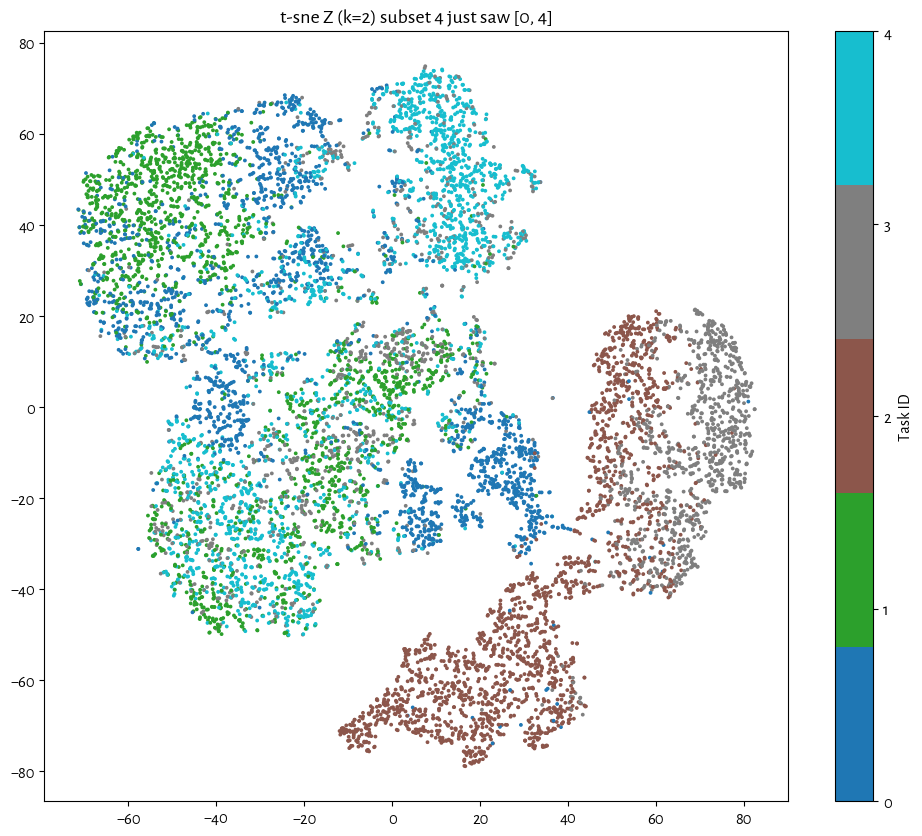

In [ ]:
# plot
plt.figure(figsize=(12, 10))

seen_indices = torch.tensor([], dtype=torch.long)
for composition in TASK_COMP[:active_task+1]:
    for class_label in composition:
        seen_indices = torch.cat([seen_indices, torch.where(joint_dataset.targets == class_label)[0]])

# seen_indices to determine alpha
alpha = torch.ones(len(joint_dataset)) * 0.1
alpha[seen_indices] = 1.0

cmap = plt.get_cmap('tab10', 5)

plt.scatter(
    z_2d[:, 0], z_2d[:, 1], 
    c=joint_dataset.taskid.int(),
    alpha=alpha,
    cmap=cmap,
    s=3.0)
# plt.colorbar()
plt.colorbar(cmap=cmap, ticks=range(5), label="Task ID")
plt.title(f"t-sne Z (k=2) subset {active_task} just saw {TASK_COMP[active_task]}")
plt.show()

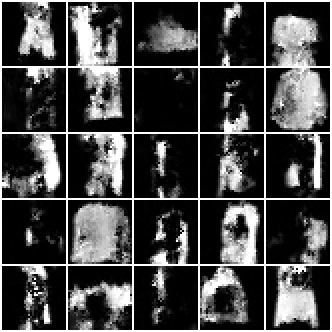

In [ ]:
model.eval()
model.use_task_subset(2)
display_batch(model.generate(25), scale=2, rows=5)

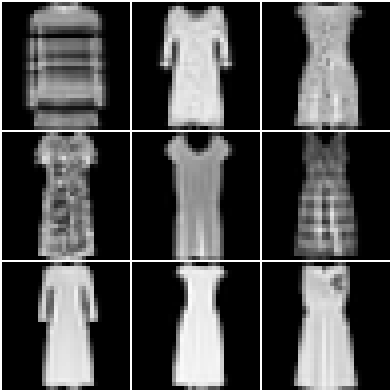

In [ ]:
x, _ = random_batch(test_sets[3], 9)
x = x.cuda()
display_batch(x)

tensor(3.0937, device='cuda:0', grad_fn=<DivBackward0>)


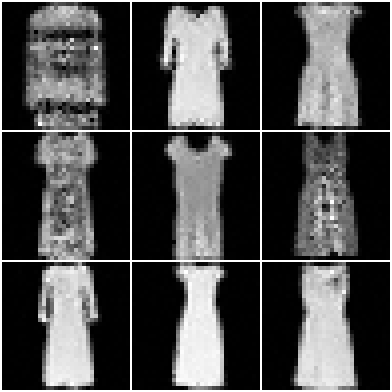

In [ ]:
model.use_task_subset(0)

likelihood, _ = model.forward(x, use_mode=[True, False, False], decode_from_p=[True, False, False])
likelihood_b, _ = model.forward(x, use_mode=[False, False, False], decode_from_p=[False, False, False])

# MSE
mse = torch.mean((likelihood.samples - x)**2)
mse_b = torch.mean((likelihood_b.samples - x)**2)

print(mse/mse_b)
display_batch(likelihood_b.samples)

In [41]:
import seaborn as sns
from surprisenet.task_inference import sample


model.cuda().eval()



novelty_scores: t.Dict[int, t.List[torch.Tensor]] = {}


task_inference = model.task_inference_strategy
task_inference.k = 1
# forward_func = super(pn.SurpriseNetVariationalAutoEncoder, model).multi_forward

for subset in range(5):
    novelty_scores[subset] = []

    for label, test_set in enumerate(test_sets):
        dataloader = DataLoader(test_set, batch_size=256, shuffle=False)

        novelty = torch.tensor([], dtype=torch.float32)
        model.use_task_subset(subset)
        for x, y in tqdm(dataloader):
            new_score = task_inference._novelty_score(x.cuda()).cpu()
            # new_score, _ = sample(forward_func, x.cuda())
            novelty = torch.cat((novelty, new_score.cpu()))
    
        novelty_scores[subset].append(novelty)


100%|██████████| 4/4 [00:01<00:00,  3.76it/s]


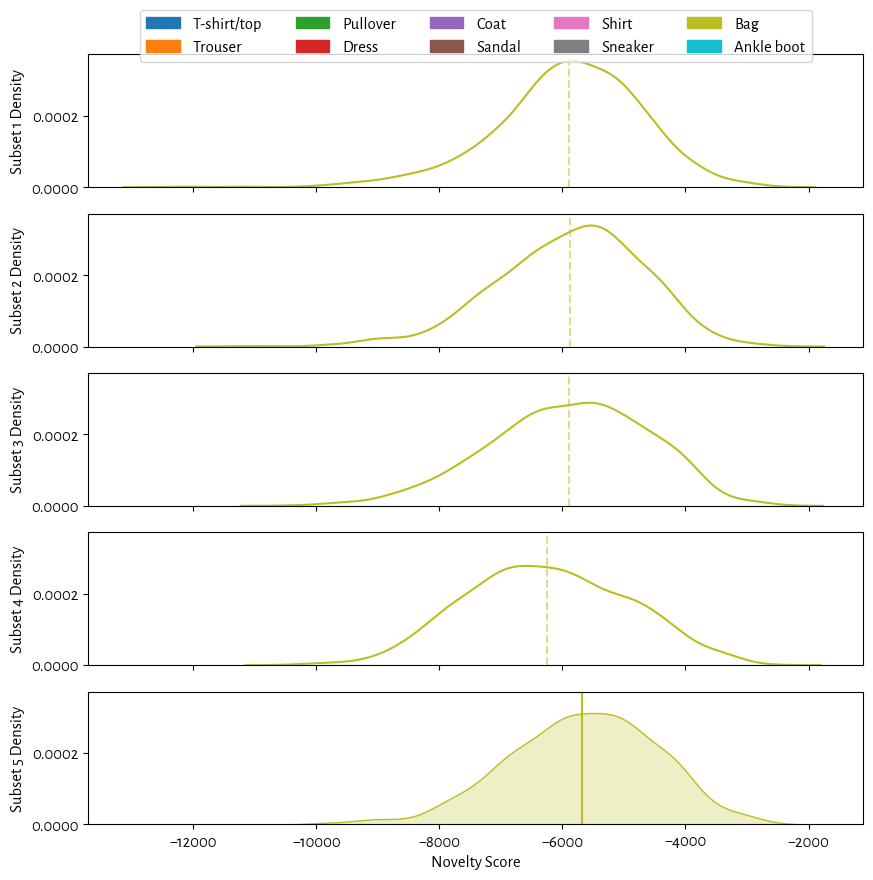

In [40]:

# Subplots
from matplotlib.ticker import FormatStrFormatter
import matplotlib.patches as mpatches



fig, axes = plt.subplots(5, 1, figsize=(10, 2*5), sharex=True, sharey=True)
# Remove padding

# flattent axes
axes = axes.flatten()

for subset, class_novelty in novelty_scores.items():
    for class_label, novelty in enumerate(class_novelty):
        if class_label != 8:
            continue
        in_task = class_label in TASK_COMP[subset]
        
        sns.kdeplot(novelty, label=f"{label} {subset}", ax=axes[subset], fill=in_task, color=f"C{class_label}")

        if in_task:
            axes[subset].axvline(novelty.mean(), color=f"C{class_label}", linestyle="-")
        else:
            axes[subset].axvline(novelty.mean(), color=f"C{class_label}", linestyle="--", alpha=0.5)

    # for task_id, (c_a, c_b) in enumerate(zip(range(0, 10, 2), range(1, 10, 2))):
    #     print(c_a, c_b)
    #     novelty = torch.cat((class_novelty[c_a], class_novelty[c_b]))

    #     in_task = task_id == subset

    #     # if not in_task:
    #     #     continue

    #     sns.kdeplot(novelty, label=f"{c_a} {c_b}", ax=axes[subset], fill=in_task, color=f"C{c_a}")

    
    axes[subset].set_ylabel(f"Subset {subset+1} Density")


# Change y axis units
for ax in axes:
    ax.set_xlabel("Novelty Score")

# Legend
patches = [mpatches.Patch(color=f'C{i}', label='The red data') for i in range(10)]

# fashion mnist labels
fmnist_label = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]


axes[0].legend(patches, fmnist_label, loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.4))


In [6]:
from tqdm import tqdm
model.cuda()
model.eval()

class_task_count = torch.zeros(10, 5)

with torch.no_grad():
    for class_label, test_set in enumerate(test_sets):
        dataloader = DataLoader(test_set, batch_size=256, shuffle=False)

        print("Testing on class", class_label)
        for x, y in tqdm(dataloader):
            x = x.cuda()
            out = model.multi_forward(x)
            for subset_pred in out.pred_exp_id:
                class_task_count[class_label, subset_pred] += 1


Testing on class 0


100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Testing on class 1


100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


Testing on class 2


100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


Testing on class 3


100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


Testing on class 4


100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Testing on class 5


100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Testing on class 6


100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


Testing on class 7


100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Testing on class 8


100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Testing on class 9


100%|██████████| 4/4 [00:07<00:00,  1.86s/it]


In [8]:
task_confusion = torch.zeros(5, 5)

for true_task, composition in enumerate(TASK_COMP):
    for class_label in composition:
        task_confusion[true_task] += class_task_count[class_label]
task_confusion

tensor([[1632.,  262.,   60.,   16.,   30.],
        [ 265., 1463.,  155.,   55.,   62.],
        [  57.,  707.,  881.,  252.,  103.],
        [ 276.,  517.,  199.,  855.,  153.],
        [ 185.,  262.,  424.,  304.,  825.]])

Text(0, 0.5, 'Class')

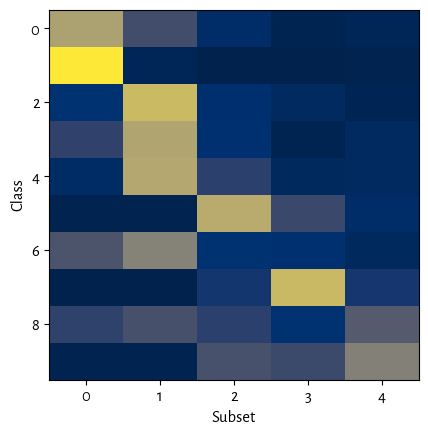

In [26]:
# class_task_count
# twice as wide as tall
# plt.figure(figsize=(10, 5))
plt.imshow(class_task_count, aspect=0.5)
plt.xlabel("Subset")
plt.ylabel("Class")


tensor(0.5656)

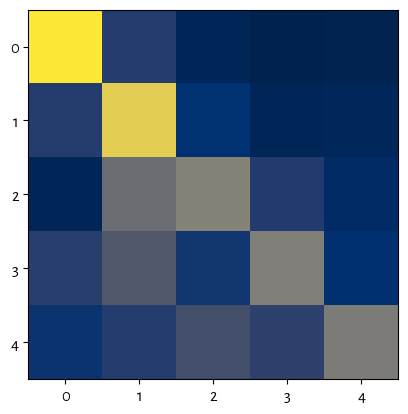

In [9]:


plt.imshow(task_confusion)

# What percentage lies on the diagonal?
task_confusion.diag().sum() / task_confusion.sum()